Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
from torch.utils.data import DataLoader, TensorDataset, Dataset
import operator
import pickle
import tqdm
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/NLP_Project')

%cd /content/drive/My Drive/NLP_Project

import data_loader

Mounted at /content/drive
/content/drive/My Drive/NLP_Ex4


In [ ]:
!ls

 data_loader.py		   stanfordSentimentTreebank	        train_validation_loss.png
'Ex4 (1).pdf'		   train_validation_accuracy_lstm.png   train_validation_loss_w2v.png
 exercise_blanks.py	   train_validation_accuracy.png        transformer_accuracy_plot.png
 __pycache__		   train_validation_accuracy_w2v.png    transformer_loss_plot.png
 results_transformer.txt   train_validation_loss_lstm.png       w2v_dict.pkl


Constants

In [ ]:
SEQ_LEN = 52
W2V_EMBEDDING_DIM = 300
HIDDEN_DIM = 100
NUM_LAYERS = 2

ONEHOT_AVERAGE = "onehot_average"
W2V_AVERAGE = "w2v_average"
W2V_SEQUENCE = "w2v_sequence"

TRAIN = "train"
VAL = "val"
TEST = "test"

Helper methods and classes

In [ ]:
def get_available_device():
    """
    Allows training on GPU if available. Can help with running things faster when a GPU with cuda is
    available but not a most...
    Given a device, one can use module.to(device)
    and criterion.to(device) so that all the computations will be done on the GPU.
    """
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)


def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)


def save_model(model, path, epoch, optimizer):
    """
    Utility function for saving checkpoint of a model, so training or evaluation can be executed later on.
    :param model: torch module representing the model
    :param optimizer: torch optimizer used for training the module
    :param path: path to save the checkpoint into
    """
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, path)


def load(model, path, optimizer):
    """
    Loads the state (weights, paramters...) of a model which was saved with save_model
    :param model: should be the same model as the one which was saved in the path
    :param path: path to the saved checkpoint
    :param optimizer: should be the same optimizer as the one which was saved in the path
    """
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

Data utilities

In [ ]:
def load_word2vec():
    """ Load Word2Vec Vectors
        Return:
            wv_from_bin: All 3 million embeddings, each lengh 300
    """
    import gensim.downloader as api
    wv_from_bin = api.load("word2vec-google-news-300")
    vocab = list(wv_from_bin.key_to_index.keys())
    print(wv_from_bin.key_to_index[vocab[0]])
    print("Loaded vocab size %i" % len(vocab))
    return wv_from_bin


def create_or_load_slim_w2v(words_list, cache_w2v=False):
    """
    returns word2vec dict only for words which appear in the dataset.
    :param words_list: list of words to use for the w2v dict
    :param cache_w2v: whether to save locally the small w2v dictionary
    :return: dictionary which maps the known words to their vectors
    """
    w2v_path = "w2v_dict.pkl"
    if not os.path.exists(w2v_path):
        full_w2v = load_word2vec()
        w2v_emb_dict = {k: full_w2v[k] for k in words_list if k in full_w2v}
        if cache_w2v:
            save_pickle(w2v_emb_dict, w2v_path)
    else:
        w2v_emb_dict = load_pickle(w2v_path)
    return w2v_emb_dict


def get_w2v_average(sent, word_to_vec, embedding_dim):
    """
    This method gets a sentence and returns the average word embedding of the words consisting
    the sentence.
    :param sent: the sentence object
    :param word_to_vec: a dictionary mapping words to their vector embeddings
    :param embedding_dim: the dimension of the word embedding vectors
    :return The average embedding vector as numpy ndarray.
    """
    # Extract tokens from the Sentence object
    tokens = sent.text  # 'text' is a list of tokens in the Sentence object

    # Collect embeddings for tokens present in word_to_vec
    embeddings = [word_to_vec[word] for word in tokens if word in word_to_vec]

    # If no embeddings were found, return a zero vector
    if not embeddings:
        return np.zeros(embedding_dim, dtype=np.float32)

    # Compute and return the average of the embeddings
    return np.mean(embeddings, axis=0)


def get_one_hot(size, ind):
    """
    this method returns a one-hot vector of the given size, where the 1 is placed in the ind entry.
    :param size: the size of the vector
    :param ind: the entry index to turn to 1
    :return: numpy ndarray which represents the one-hot vector
    """
    one_hot = np.zeros(size, dtype=np.float32)
    one_hot[ind] = 1.0
    return one_hot


def average_one_hots(sent, word_to_ind):
    """
    this method gets a sentence, and a mapping between words to indices, and returns the average
    one-hot embedding of the tokens in the sentence.
    :param sent: a sentence object.
    :param word_to_ind: a mapping between words to indices
    :return:
    """
    # Extract tokens directly from the Sentence object
    tokens = sent.text  # 'text' is a list of tokens in the Sentence object

    vocab_size = len(word_to_ind)
    sentence_vectors = [
        get_one_hot(vocab_size, word_to_ind[word])
        for word in tokens if word in word_to_ind
    ]

    # Handle cases where no tokens in the sentence map to the vocabulary
    if not sentence_vectors:
        return np.zeros(vocab_size, dtype=np.float32)

    # Return the average one-hot embedding
    return np.mean(sentence_vectors, axis=0)


def get_word_to_ind(words_list):
    """
    this function gets a list of words, and returns a mapping between
    words to their index.
    :param words_list: a list of words
    :return: the dictionary mapping words to the index
    """
    return {word: idx for idx, word in enumerate(words_list)}


def sentence_to_embedding(sent, word_to_vec, seq_len, embedding_dim=300):
    """
    Converts a sentence to a fixed-length sequence of word embeddings.
    """
    tokens = sent.text  # Extract tokens from the sentence object
    embeddings = [
        word_to_vec.get(token, np.zeros(embedding_dim, dtype=np.float32))
        for token in tokens[:seq_len]
    ]

    # Add padding for sentences shorter than seq_len
    if len(embeddings) < seq_len:
        padding = [np.zeros(embedding_dim, dtype=np.float32)] * (seq_len - len(embeddings))
        embeddings.extend(padding)

    return np.array(embeddings, dtype=np.float32)


class OnlineDataset(Dataset):
    """
    A pytorch dataset which generates model inputs on the fly from sentences of SentimentTreeBank
    """

    def __init__(self, sent_data, sent_func, sent_func_kwargs):
        """
        :param sent_data: list of sentences from SentimentTreeBank
        :param sent_func: Function which converts a sentence to an input datapoint
        :param sent_func_kwargs: fixed keyword arguments for the state_func
        """
        self.data = sent_data
        self.sent_func = sent_func
        self.sent_func_kwargs = sent_func_kwargs

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sent = self.data[idx]
        sent_emb = self.sent_func(sent, **self.sent_func_kwargs)
        sent_label = sent.sentiment_class
        return sent_emb, sent_label


class DataManager():
    """
    Utility class for handling all data management task. Can be used to get iterators for training and
    evaluation.
    """

    def __init__(self, data_type=ONEHOT_AVERAGE, use_sub_phrases=True, dataset_path="/content/drive/My Drive/NLP_Project/stanfordSentimentTreebank", batch_size=50,
                 embedding_dim=None):
        """
        builds the data manager used for training and evaluation.
        :param data_type: one of ONEHOT_AVERAGE, W2V_AVERAGE and W2V_SEQUENCE
        :param use_sub_phrases: if true, training data will include all sub-phrases plus the full sentences
        :param dataset_path: path to the dataset directory
        :param batch_size: number of examples per batch
        :param embedding_dim: relevant only for the W2V data types.
        """

        # load the dataset
        self.sentiment_dataset = data_loader.SentimentTreeBank(dataset_path, split_words=True)
        # map data splits to sentences lists
        self.sentences = {}
        if use_sub_phrases:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set_phrases()
        else:
            self.sentences[TRAIN] = self.sentiment_dataset.get_train_set()

        self.sentences[VAL] = self.sentiment_dataset.get_validation_set()
        self.sentences[TEST] = self.sentiment_dataset.get_test_set()

        # map data splits to sentence input preperation functions
        words_list = list(self.sentiment_dataset.get_word_counts().keys())
        if data_type == ONEHOT_AVERAGE:
            self.sent_func = average_one_hots
            self.sent_func_kwargs = {"word_to_ind": get_word_to_ind(words_list)}
        elif data_type == W2V_SEQUENCE:
            self.sent_func = sentence_to_embedding

            self.sent_func_kwargs = {"seq_len": SEQ_LEN,
                                     "word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        elif data_type == W2V_AVERAGE:
            self.sent_func = get_w2v_average
            words_list = list(self.sentiment_dataset.get_word_counts().keys())
            self.sent_func_kwargs = {"word_to_vec": create_or_load_slim_w2v(words_list),
                                     "embedding_dim": embedding_dim
                                     }
        else:
            raise ValueError("invalid data_type: {}".format(data_type))
        # map data splits to torch datasets and iterators
        self.torch_datasets = {k: OnlineDataset(sentences, self.sent_func, self.sent_func_kwargs) for
                               k, sentences in self.sentences.items()}
        self.torch_iterators = {k: DataLoader(dataset, batch_size=batch_size, shuffle=k == TRAIN)
                                for k, dataset in self.torch_datasets.items()}

    def get_torch_iterator(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: torch batches iterator for this part of the datset
        """
        return self.torch_iterators[data_subset]

    def get_labels(self, data_subset=TRAIN):
        """
        :param data_subset: one of TRAIN VAL and TEST
        :return: numpy array with the labels of the requested part of the datset in the same order of the
        examples.
        """
        return np.array([sent.sentiment_class for sent in self.sentences[data_subset]])

    def get_input_shape(self):
        """
        :return: the shape of a single example from this dataset (only of x, ignoring y the label).
        """
        return self.torch_datasets[TRAIN][0][0].shape

Models

In [ ]:
class LSTM(nn.Module):
    """
    An LSTM for sentiment analysis with architecture as described in the exercise description.
    """
    def __init__(
        self,
        embedding_dim: int,
        hidden_dim: int,
        n_layers: int,
        dropout_rate: float,
    ):
        super().__init__()

        # Store the hidden state dimension and the number of LSTM layers
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True,
        )

        # Define a dropout layer to prevent overfitting
        self.dropout = nn.Dropout(dropout_rate)

        # Define the classifier layer (a fully connected layer)
        # The input features are 2 * hidden_dim because it's a bidirectional LSTM
        self.classifier = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=1,
        )

    def forward(self, embedded_text: torch.Tensor) -> torch.Tensor:
        # Pass the embedded text through the LSTM layer
        lstm_output, (hidden_states, _) = self.lstm(embedded_text)

        # Extract the final hidden state by combining the forward and backward hidden states
        final_hidden_state = self._get_final_hidden_state(hidden_states)

        # Apply dropout for regularization
        dropped_hidden = self.dropout(final_hidden_state)

        # Pass the hidden state through the classifier to get logits
        logits = self.classifier(dropped_hidden)

        return logits

    def _get_final_hidden_state(self, hidden_states: torch.Tensor) -> torch.Tensor:
        """
        This helper function retrieves the final hidden state from the LSTM output.

        Arguments:
            hidden_states: Tensor containing hidden states from all layers of the LSTM.

        Returns:
            Concatenated final hidden states from the forward and backward LSTM layers.
        """
        # Get the forward and backward hidden states (last two layers of the bidirectional LSTM)
        forward_hidden = hidden_states[-2, :, :]  # Last hidden state for the forward direction
        backward_hidden = hidden_states[-1, :, :]  # Last hidden state for the backward direction

        # Concatenate forward and backward hidden states along the feature dimension
        return torch.cat((forward_hidden, backward_hidden), dim=1)

    def predict(self, embedded_text: torch.Tensor) -> torch.Tensor:
        with torch.no_grad():
            # Get the raw logits from the forward pass
            logits = self.forward(embedded_text)

            # Apply sigmoid to the logits to get probabilities between 0 and 1
            probabilities = torch.sigmoid(logits)

            # Convert probabilities to binary predictions (0 or 1)
            predictions = (probabilities >= 0.5).float()

        return predictions



class LogLinear(nn.Module):
    """
    general class for the log-linear models for sentiment analysis.
    """
    def __init__(self, embedding_dim):
        super(LogLinear, self).__init__()
        # Define a single linear layer
        self.linear = nn.Linear(embedding_dim, 1).to(get_available_device())

    def forward(self, x):
        # Apply the linear layer to the input
        return self.linear(x.to(get_available_device()))

    def predict(self, x):
        # Apply the forward method, sigmoid activation, and round the output
        with torch.no_grad():
            logits = self.forward(x)
            probabilities = torch.sigmoid(logits)
            return (probabilities > 0.5).float()

Training functions

In [ ]:
def binary_accuracy(preds, y):
    """
    This method returns tha accuracy of the predictions, relative to the labels.
    You can choose whether to use numpy arrays or tensors here.
    :param preds: a vector of predictions
    :param y: a vector of true labels
    :return: scalar value - (<number of accurate predictions> / <number of examples>)
    """

    return


def train_epoch(model, data_iterator, optimizer, criterion):
    """
    This method operates one epoch (pass over the whole train set) of training of the given model,
    and returns the accuracy and loss for this epoch
    :param model: the model we're currently training
    :param data_iterator: an iterator, iterating over the training data for the model.
    :param optimizer: the optimizer object for the training process.
    :param criterion: the criterion object for the training process.
    """

    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(data_iterator):
        # Assume batch contains (input_tensor, label_tensor)
        inputs, labels = batch
        optimizer.zero_grad()  # Clear previous gradients
        # Forward pass

        logits = model(inputs)

        loss = criterion(logits.squeeze(), labels.float().to(get_available_device()))

        # Backward pass
        loss.backward()
        optimizer.step()

        # Update metrics
        total_loss += loss.item() * len(labels)
        predictions = (torch.sigmoid(logits.to('cpu')) > 0.5).squeeze().float()
        total_correct += (predictions == labels).sum().item()
        total_samples += len(labels)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def evaluate(model, data_iterator, criterion):
    """
    evaluate the model performance on the given data
    :param model: one of our models..
    :param data_iterator: torch data iterator for the relevant subset
    :param criterion: the loss criterion used for evaluation
    :return: tuple of (average loss over all examples, average accuracy over all examples)
    """
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in data_iterator:
            inputs, labels = batch

            # Forward pass
            logits = model(inputs)
            loss = criterion(logits.squeeze(), labels.float().to(get_available_device()))

            # Update metrics
            total_loss += loss.item() * len(labels)
            predictions = (torch.sigmoid(logits.to('cpu')) > 0.5).squeeze().float()
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def get_predictions_for_data(model, data_iter):
    """

    This function should iterate over all batches of examples from data_iter and return all of the models
    predictions as a numpy ndarray or torch tensor (or list if you prefer). the prediction should be in the
    same order of the examples returned by data_iter.
    :param model: one of the models you implemented in the exercise
    :param data_iter: torch iterator as given by the DataManager
    :return:
    """
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch in data_iter:
            inputs, _ = batch  # Only inputs are needed for predictions
            batch_predictions = model.predict(inputs)
            all_predictions.append(batch_predictions)

    # Concatenate all batch predictions into a single tensor
    return torch.cat(all_predictions, dim=0)


def train_model(model, data_manager, n_epochs, lr, weight_decay=0.):
    """
    Runs the full training procedure for the given model. The optimization should be done using the Adam
    optimizer with all parameters but learning rate and weight decay set to default.
    :param model: module of one of the models implemented in the exercise
    :param data_manager: the DataManager object
    :param n_epochs: number of times to go over the whole training set
    :param lr: learning rate to be used for optimization
    :param weight_decay: parameter for l2 regularization
    """
    # Prepare optimizer and criterion
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss().to(get_available_device())

    # Data iterators
    train_iterator = data_manager.get_torch_iterator(TRAIN)  # Corrected method call
    val_iterator = data_manager.get_torch_iterator(VAL)      # Corrected method call

    # Tracking metrics
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        # Train for one epoch
        train_loss, train_accuracy = train_epoch(model, train_iterator, optimizer, criterion)

        # Evaluate on validation set
        val_loss, val_accuracy = evaluate(model, val_iterator, criterion)

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print progress
        print(f"Epoch {epoch + 1}/{n_epochs}: "
              f"Train Loss = {train_loss:.4f}, Train Acc = {train_accuracy:.4f}, "
              f"Val Loss = {val_loss:.4f}, Val Acc = {val_accuracy:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


def train_and_evaluate(model, data_manager, n_epochs, lr, weight_decay, device, save_prefix):
    """
    Generic function for training and evaluating a sentiment analysis model.
    """
    # Move model to device
    model.to(device)

    # Train the model
    train_losses, train_accuracies, val_losses, val_accuracies = train_model(
        model, data_manager, n_epochs, lr, weight_decay
    )

    # Plot training and validation loss
    plot_metrics(train_losses, val_losses, n_epochs, "Loss", f"{save_prefix}_loss.png")

    # Plot training and validation accuracy
    plot_metrics(train_accuracies, val_accuracies, n_epochs, "Accuracy", f"{save_prefix}_accuracy.png")

    # Evaluate on test set
    test_loss, test_accuracy = evaluate_model(model, data_manager.get_torch_iterator(TEST), device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Evaluate on special subsets
    evaluate_special_subsets(model, data_manager, device)


def plot_metrics(train_values, val_values, n_epochs, metric, save_path):
    """
    Plots training and validation metrics over epochs.
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), train_values, label=f"Train {metric}")
    plt.plot(range(1, n_epochs + 1), val_values, label=f"Validation {metric}")
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"Train vs. Validation {metric}")
    plt.legend()
    plt.savefig(save_path)
    plt.show()

def evaluate_model(model, data_iterator, device):
    """
    Evaluates the model on a given dataset iterator.
    """
    criterion = nn.BCEWithLogitsLoss()
    return evaluate(model, data_iterator, criterion)


def evaluate_special_subsets(model, data_manager, device):
    """
    Evaluates the model on the special subsets of negated polarity and rare words.
    """
    special_subsets = {
        "Negated Polarity": data_loader.get_negated_polarity_examples(data_manager.sentences[TEST]),
        "Rare Words": data_loader.get_rare_words_examples(data_manager.sentences[TEST], data_manager.sentiment_dataset),
    }

    for subset_name, subset_indices in special_subsets.items():
        subset_data = torch.utils.data.Subset(data_manager.torch_datasets[TEST], subset_indices)
        subset_loader = DataLoader(subset_data, batch_size=64, shuffle=False)
        subset_loss, subset_accuracy = evaluate_model(model, subset_loader, device)
        print(f"{subset_name} - Loss: {subset_loss:.4f}, Accuracy: {subset_accuracy:.4f}")


def train_log_linear_with_one_hot():
    """
    Here comes your code for training and evaluation of the log linear model with one hot representation.
    """
    # Initialize DataManager
    data_manager = DataManager(data_type=ONEHOT_AVERAGE, batch_size=64)

    # Hyperparameters
    embedding_dim = len(data_manager.sent_func_kwargs["word_to_ind"])  # One-hot vector size

    # Initialize model, data, and train
    model = LogLinear(embedding_dim).to(get_available_device())
    data_manager = DataManager()
    train_and_evaluate(model, data_manager, n_epochs=20, lr=0.01, weight_decay=0.001, device=get_available_device(), save_prefix="one_hot")


def train_log_linear_with_w2v():
    """
    Here comes your code for training and evaluation of the log linear model with word embeddings
    representation.
    """
    # Initialize DataManager with Word2Vec configuration
    data_manager = DataManager(
        data_type=W2V_AVERAGE,
        batch_size=64,
        embedding_dim=W2V_EMBEDDING_DIM
    )

    words_list = list(data_manager.sentiment_dataset.get_word_counts().keys())
    word_to_vec = create_or_load_slim_w2v(words_list, cache_w2v=True)
    data_manager.sent_func = get_w2v_average
    data_manager.sent_func_kwargs = {"word_to_vec": word_to_vec, "embedding_dim": W2V_EMBEDDING_DIM}
    model = LogLinear(W2V_EMBEDDING_DIM)
    train_and_evaluate(model, data_manager, n_epochs=20, lr=0.01, weight_decay=0.001, device=get_available_device(), save_prefix="w2v_log_linear")


def train_lstm_with_w2v():
    """
    Training and evaluation of the LSTM model with Word2Vec representation.
    """
    # Initialize DataManager
    data_manager = DataManager(
        data_type=W2V_SEQUENCE,
        batch_size=64,
        embedding_dim=W2V_EMBEDDING_DIM
    )

    # Initialize LSTM model
    device = get_available_device()
    sentiment_model = LSTM(
        embedding_dim=W2V_EMBEDDING_DIM,
        hidden_dim=128,
        n_layers=1,
        dropout_rate=0.5
    ).to(device)

    # Train the model
    trained_model, train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model_with_device(
        model=sentiment_model,
        data_manager=data_manager,
        n_epochs=4,
        lr=0.001,
        weight_decay=0.0001,
        device=device
    )

    plot_metrics(train_loss_history, val_loss_history, 4, "Loss", "train_validation_loss_lstm.png")
    plot_metrics(train_acc_history, val_acc_history, 4, "Accuracy", "train_validation_accuracy_lstm.png")

    # Evaluate the model on the test set
    test_iterator = data_manager.get_torch_iterator(TEST)
    criterion = nn.BCEWithLogitsLoss()
    test_loss, test_accuracy = evaluate_with_device(trained_model, test_iterator, criterion, device)
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Evaluate the model on special subsets
    evaluate_special_subsets(trained_model, data_manager, device)


LSTM Training Helper Functions

In [ ]:
def train_model_with_device(model, data_manager, n_epochs, lr, weight_decay, device):
    """
    Modified training function that ensures device consistency for inputs and labels.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(n_epochs):
        # Train for one epoch
        model.train()
        train_loss, train_accuracy = 0.0, 0.0
        total_samples = 0

        for batch in data_manager.get_torch_iterator(TRAIN):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(inputs)
            loss = criterion(logits.squeeze(), labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(labels)
            predictions = (torch.sigmoid(logits) > 0.5).squeeze().float()
            train_accuracy += (predictions == labels).sum().item()
            total_samples += len(labels)

        train_losses.append(train_loss / total_samples)
        train_accuracies.append(train_accuracy / total_samples)

        # Evaluate on validation set
        model.eval()
        val_loss, val_accuracy = evaluate_with_device(model, data_manager.get_torch_iterator(VAL), criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{n_epochs}: "
              f"Train Loss = {train_losses[-1]:.4f}, Train Acc = {train_accuracies[-1]:.4f}, "
              f"Val Loss = {val_losses[-1]:.4f}, Val Acc = {val_accuracies[-1]:.4f}")

    return model, train_losses, train_accuracies, val_losses, val_accuracies


def evaluate_with_device(model, data_iterator, criterion, device):
    """
    Evaluate the model on a given dataset with device handling.
    """
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0.0, 0

    with torch.no_grad():
        for batch in data_iterator:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            logits = model(inputs)
            loss = criterion(logits.squeeze(), labels.float())
            total_loss += loss.item() * len(labels)
            predictions = (torch.sigmoid(logits) > 0.5).squeeze().float()
            total_correct += (predictions == labels).sum().item()
            total_samples += len(labels)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


Epoch 1/4: Train Loss = 0.3489, Train Acc = 0.8486, Val Loss = 0.3962, Val Acc = 0.8285
Epoch 2/4: Train Loss = 0.2809, Train Acc = 0.8827, Val Loss = 0.3765, Val Acc = 0.8389
Epoch 3/4: Train Loss = 0.2532, Train Acc = 0.8971, Val Loss = 0.3918, Val Acc = 0.8326
Epoch 4/4: Train Loss = 0.2331, Train Acc = 0.9084, Val Loss = 0.3930, Val Acc = 0.8586


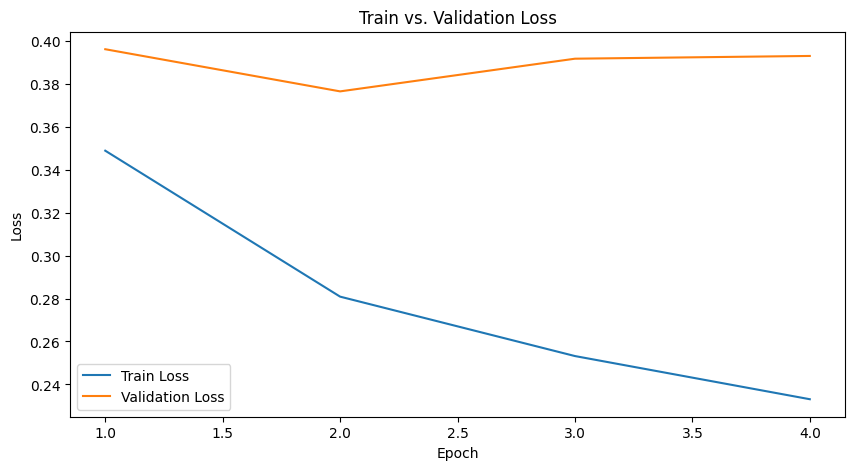

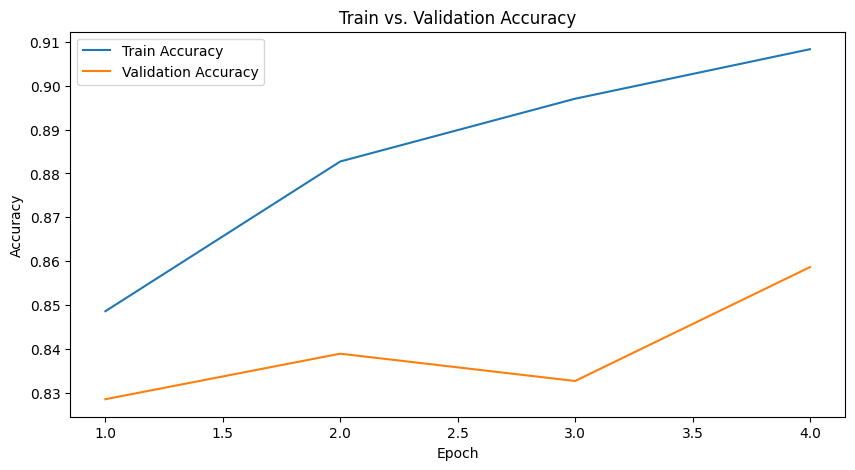

Test Loss: 0.3414, Test Accuracy: 0.8617
Negated Polarity - Loss: 0.7978, Accuracy: 0.6935
Rare Words - Loss: 0.5431, Accuracy: 0.8000


In [ ]:
if __name__ == '__main__':
    train_log_linear_with_one_hot()
    train_log_linear_with_w2v()
    train_lstm_with_w2v()